In [ ]:
# Imports and plotting setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from option_pricing import bs_delta_hedge

In [2]:
# Common parameters for all experiments
spot = 100.0
strike = 100.0
expiry = 1.0  # years
rate = 0.01
dividend_yield = 0.0
sim_vol = 0.2
base_mark_vol = 0.2
n_steps = 252
hedge_freq_daily = 252
n_paths = 50_0

hist_min = -5.0
hist_max = 5.0
n_bins = 100

In [3]:
# Helper to run a single experiment and return a DataFrame row
def run_experiment(product_type, payoff_type, mark_vol, hedge_freq, seed):
    result = bs_delta_hedge(
        product_type=product_type,
        payoff_type=payoff_type,
        strike=strike,
        expiry=expiry,
        rate=rate,
        dividend_yield=dividend_yield,
        spot=spot,
        sim_vol=sim_vol,
        mark_vol=mark_vol,
        n_steps=n_steps,
        hedge_freq=hedge_freq,
        n_paths=n_paths,
        hist_min=hist_min,
        hist_max=hist_max,
        n_bins=n_bins,
        seed=seed,
    )

    row = {
        "product_type": product_type,
        "payoff_type": payoff_type,
        "mark_vol": mark_vol,
        "hedge_freq": hedge_freq,
        "pnl_mean": result["pnl_mean"],
        "pnl_std": result["pnl_std"],
        "hist_bin_edges": result["hist_bin_edges"],
        "hist_counts": result["hist_counts"],
    }
    return row

## Effect of Volatility Misspecification

We fix the simulation volatility and hedging frequency, and vary the
mark-to-market volatility used for pricing and delta hedging.

In [4]:
mark_vols = [0.12, 0.16, 0.2, 0.24, 0.3]
products = [("european", "call"), ("european", "put"), ("digital", "call"), ("digital", "put")]

rows = []
for product_type, payoff_type in products:
    for mv in mark_vols:
        row = run_experiment(
            product_type=product_type,
            payoff_type=payoff_type,
            mark_vol=mv,
            hedge_freq=hedge_freq_daily,
            seed=42,
        )
        rows.append(row)

misspec_df = pd.DataFrame(rows)
misspec_df[["product_type", "payoff_type", "mark_vol", "pnl_mean", "pnl_std"]]

,product_type,payoff_type,mark_vol,pnl_mean,pnl_std
0,european,call,0.12,3.092527,1.602129
1,european,call,0.16,1.570594,0.809730
2,european,call,0.20,0.032032,0.412730
3,european,call,0.24,-1.520797,0.678197
4,european,call,0.30,-3.866223,1.264427
5,european,put,0.12,3.092527,1.602129
6,european,put,0.16,1.570594,0.809730
7,european,put,0.20,0.032032,0.412730
8,european,put,0.24,-1.520797,0.678197
9,european,put,0.30,-3.866223,1.264427


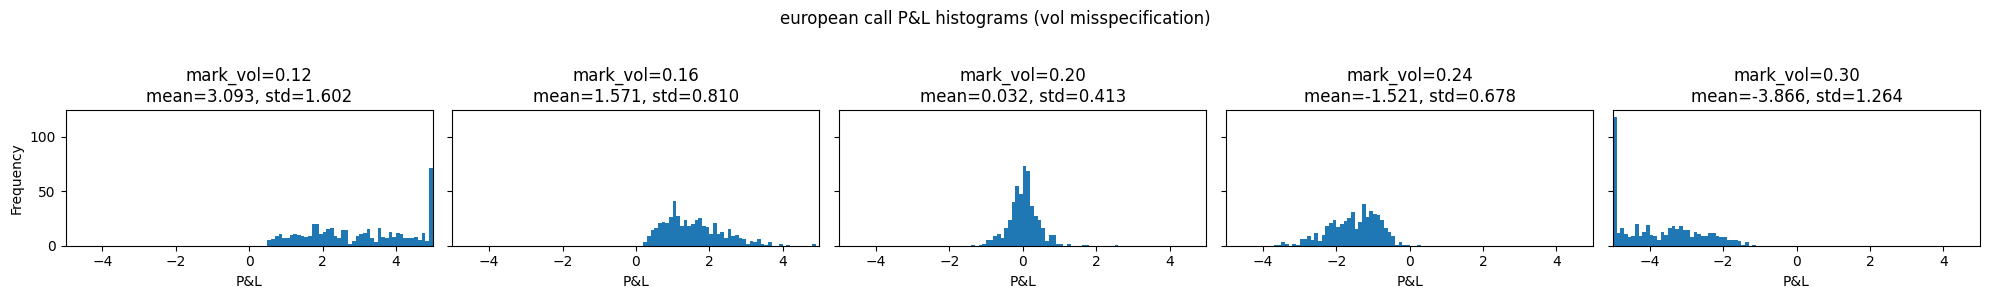

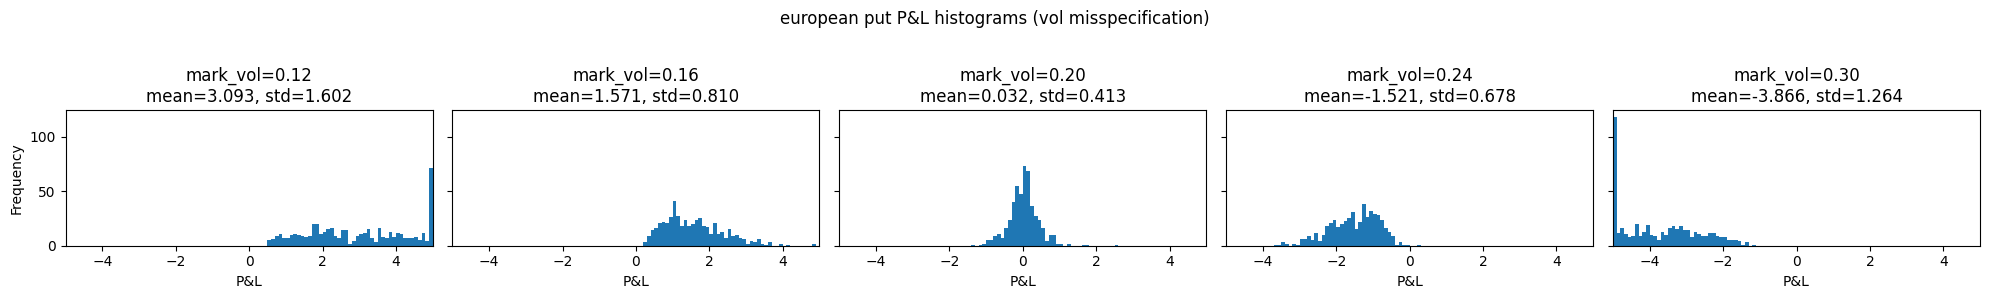

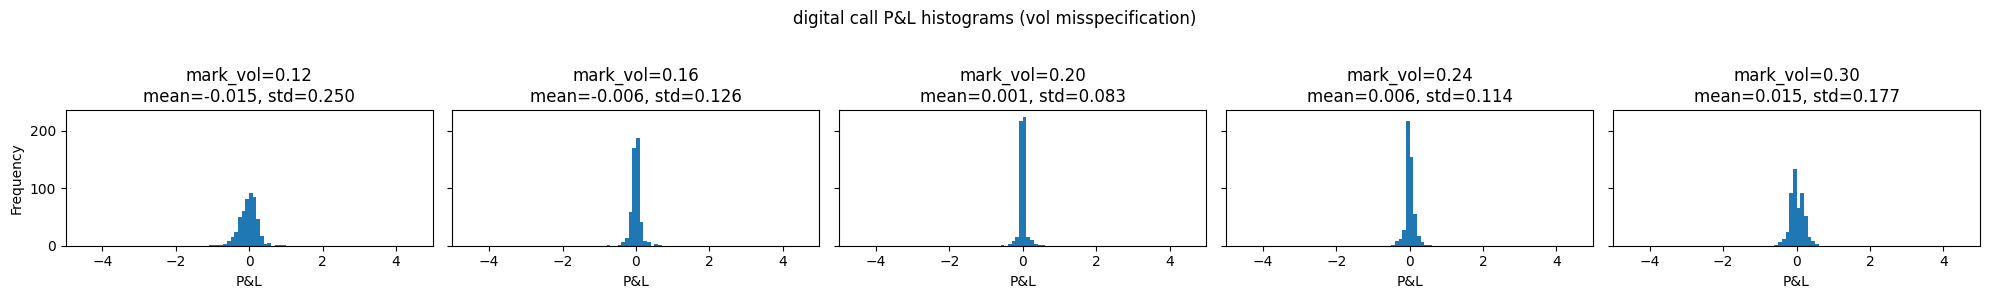

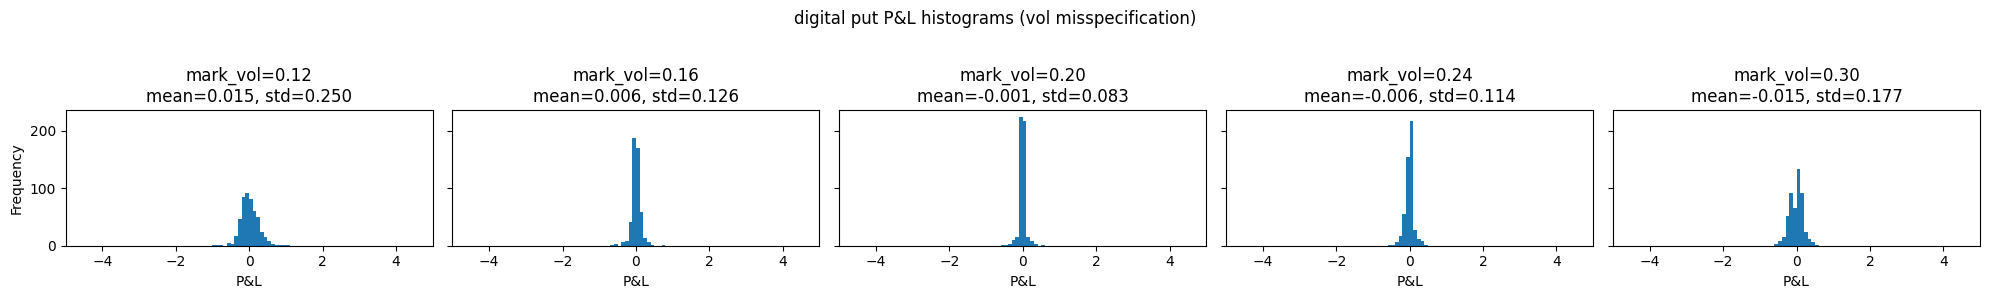

In [6]:
# Plot P&L histograms for volatility misspecification for each product/payoff
def plot_histograms_for_product(product_type, payoff_type):
    subset = misspec_df[(misspec_df.product_type == product_type) & (misspec_df.payoff_type == payoff_type)].sort_values("mark_vol")
    n = len(subset)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 3), sharey=True)
    if n == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, subset.iterrows()):
        edges = np.asarray(row["hist_bin_edges"])
        counts = np.asarray(row["hist_counts"])
        centers = 0.5 * (edges[:-1] + edges[1:])
        width = edges[1] - edges[0]
        ax.bar(centers, counts, width=width, align="center")
        ax.set_xlim(hist_min, hist_max)
        ax.set_title(f"mark_vol={row['mark_vol']:.2f}\nmean={row['pnl_mean']:.3f}, std={row['pnl_std']:.3f}")
        ax.set_xlabel("P&L")
    axes[0].set_ylabel("Frequency")
    fig.suptitle(f"{product_type} {payoff_type} P&L histograms (vol misspecification)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])

for product_type, payoff_type in products:
    plot_histograms_for_product(product_type, payoff_type)

## Effect of Hedging Frequency

We now fix sim_vol = mark_vol and vary the hedging frequency.

In [7]:
hedge_freqs = [252, 52, 12, 4]
rows_freq = []
for product_type, payoff_type in products:
    for hf in hedge_freqs:
        row = run_experiment(
            product_type=product_type,
            payoff_type=payoff_type,
            mark_vol=base_mark_vol,
            hedge_freq=hf,
            seed=123,
        )
        rows_freq.append(row)

freq_df = pd.DataFrame(rows_freq)
freq_df[["product_type", "payoff_type", "hedge_freq", "pnl_mean", "pnl_std"]]

,product_type,payoff_type,hedge_freq,pnl_mean,pnl_std
0,european,call,252,-0.027944,0.454898
1,european,call,52,-0.059733,0.926024
2,european,call,12,-0.097422,1.814618
3,european,call,4,-0.135546,3.205446
4,european,put,252,-0.027944,0.454898
5,european,put,52,-0.059733,0.926024
6,european,put,12,-0.097422,1.814618
7,european,put,4,-0.135546,3.205446
8,digital,call,252,-0.001382,0.103998
9,digital,call,52,0.003983,0.150470


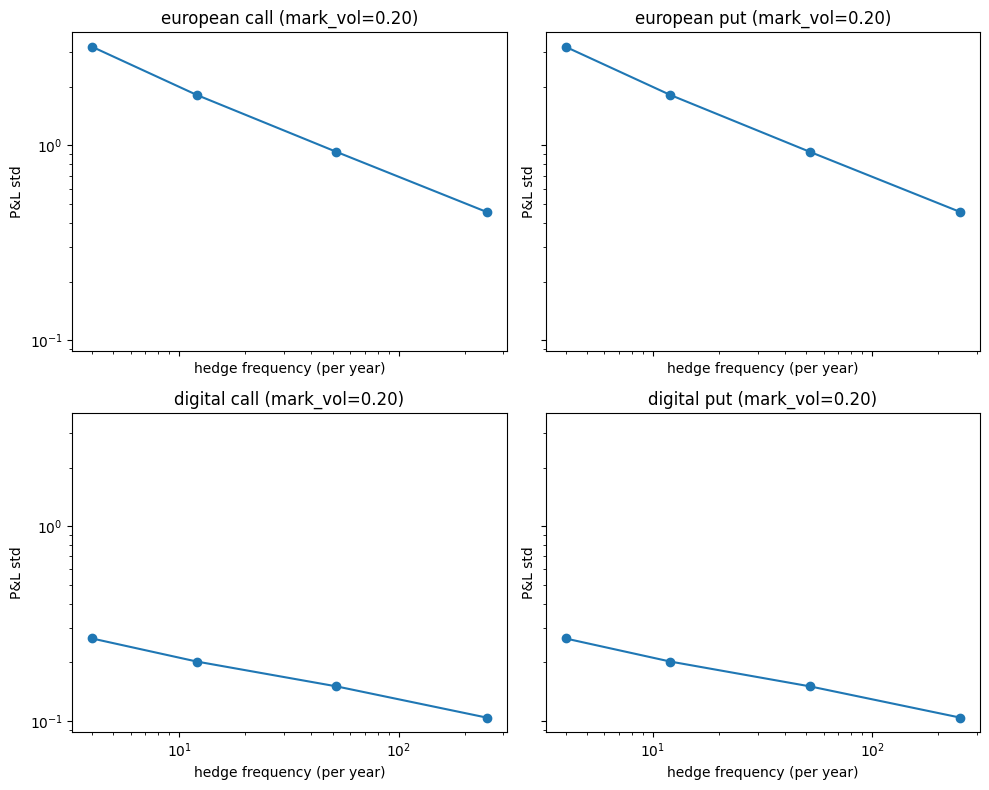

In [9]:
# Plot how P&L standard deviation scales with hedging frequency
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.ravel()
for ax, (product_type, payoff_type) in zip(axes, products):
    subset = freq_df[(freq_df.product_type == product_type) & (freq_df.payoff_type == payoff_type)]
    ax.plot(subset["hedge_freq"], subset["pnl_std"], marker="o")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"{product_type} {payoff_type} (mark_vol={base_mark_vol:.2f})")
    ax.set_xlabel("hedge frequency (per year)")
    ax.set_ylabel("P&L std")
plt.tight_layout()

In [12]:
# Optional: export summary statistics to CSV for spreadsheet analysis
display(misspec_df)
display(freq_df)

,product_type,payoff_type,mark_vol,hedge_freq,pnl_mean,pnl_std,hist_bin_edges,hist_counts
0,european,call,0.12,252,3.092527,1.602129,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,european,call,0.16,252,1.570594,0.809730,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,european,call,0.20,252,0.032032,0.412730,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,european,call,0.24,252,-1.520797,0.678197,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
4,european,call,0.30,252,-3.866223,1.264427,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[118, 12, 16, 11, 8, 9, 20, 9, 13, 19, 10, 9, ..."
5,european,put,0.12,252,3.092527,1.602129,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,european,put,0.16,252,1.570594,0.809730,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,european,put,0.20,252,0.032032,0.412730,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,european,put,0.24,252,-1.520797,0.678197,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
9,european,put,0.30,252,-3.866223,1.264427,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[118, 12, 16, 11, 8, 9, 20, 9, 13, 19, 10, 9, ..."


,product_type,payoff_type,mark_vol,hedge_freq,pnl_mean,pnl_std,hist_bin_edges,hist_counts
0,european,call,0.2,252,-0.027944,0.454898,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,european,call,0.2,52,-0.059733,0.926024,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,european,call,0.2,12,-0.097422,1.814618,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 3, 2, 0, 5, 2, ..."
3,european,call,0.2,4,-0.135546,3.205446,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[32, 2, 6, 4, 0, 2, 1, 5, 5, 2, 4, 2, 4, 4, 3,..."
4,european,put,0.2,252,-0.027944,0.454898,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,european,put,0.2,52,-0.059733,0.926024,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
6,european,put,0.2,12,-0.097422,1.814618,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 3, 2, 0, 5, 2, ..."
7,european,put,0.2,4,-0.135546,3.205446,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[32, 2, 6, 4, 0, 2, 1, 5, 5, 2, 4, 2, 4, 4, 3,..."
8,digital,call,0.2,252,-0.001382,0.103998,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,digital,call,0.2,52,0.003983,0.150470,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
